### Importe de librerias

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import nltk 
import string
from nltk.corpus import stopwords
import collections
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
np.random.seed(1)
tf.random.set_seed(1)
from keras.utils.vis_utils import plot_model
#import visualkeras

import matplotlib.pyplot as plt
import os

from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score

# Redes Neuronales

Datasets a utilizar

In [3]:
#datasets normales
ds_train = pd.read_csv('properati_argentina_train.csv')
ds_test = pd.read_csv('properati_argentina_test.csv')

### Ingenieria de caracteristicas para datasets compelto

In [4]:
ds_train.head()

#preguntar si precio_xm2 deberia estar (viene del TP1)

,Unnamed: 0,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,precioxm2_relativo_q
0,0,-34.601807,-58.469965,Departamento,2.0,1.0,53.0,49.0,80000.0,bajo
1,1,-34.580088,-58.424965,Departamento,2.0,1.0,35.0,35.0,79900.0,medio
2,2,-34.551481,-58.452358,Departamento,1.0,1.0,25.0,20.0,69000.0,medio
3,3,-34.632290,-58.464844,Departamento,5.0,3.0,75.0,75.0,150000.0,medio
4,4,-34.549279,-58.463074,Departamento,2.0,1.0,46.0,34.0,85000.0,bajo


In [5]:
#dropeamos Unamed:0
ds_train.drop(columns=["Unnamed: 0"], inplace=True)
ds_test.drop(columns=["Unnamed: 0"], inplace=True)

#cambio nombre de columna precioxm2_relativo_q
ds_train.rename(columns={'precioxm2_relativo_q':'tipo_precio'}, inplace=True)
ds_test.rename(columns={'precioxm2_relativo_q':'tipo_precio'}, inplace=True)

Aplicamos dummies a la variable property_type y precioxm2_relativo_q

In [6]:
ds_train = pd.get_dummies(ds_train, columns=["property_type"], drop_first=True)

ds_test =  pd.get_dummies(ds_test, columns=["property_type"], drop_first=True)

Normalizamos las variables con valores numericos

In [7]:

columnas_elegidas = ['property_rooms', 'property_bedrooms', 'property_surface_total', "property_surface_covered"]
sc = StandardScaler()

#estandarizo variables cuantitativas en train
x = ds_train.loc[:, columnas_elegidas].values
x = sc.fit_transform(x)
ds_train[columnas_elegidas] = x 

#estandarizo variables cuantitativas en test
y = ds_test.loc[:, columnas_elegidas].values
y = sc.transform(y)
ds_test[columnas_elegidas] = y


In [8]:
ds_train.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,tipo_precio,property_type_Departamento,property_type_PH
0,-34.601807,-58.469965,-0.573441,-0.904594,-0.356237,-0.417925,80000.0,bajo,1,0
1,-34.580088,-58.424965,-0.573441,-0.904594,-0.609345,-0.762050,79900.0,medio,1,0
2,-34.551481,-58.452358,-1.454585,-0.904594,-0.749961,-1.130756,69000.0,medio,1,0
3,-34.632290,-58.464844,2.069988,1.417020,-0.046882,0.221165,150000.0,medio,1,0
4,-34.549279,-58.463074,-0.573441,-0.904594,-0.454668,-0.786631,85000.0,bajo,1,0


In [9]:
ds_test.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,tipo_precio,property_type_Departamento,property_type_PH
0,-34.598679,-58.499717,-1.454585,-0.904594,-0.567160,-0.934113,85000.0,medio,1,0
1,-34.574987,-58.420611,-0.573441,-0.904594,1.007737,0.098263,520000.0,alto,1,0
2,-34.586527,-58.398279,-0.573441,-0.904594,-0.496852,-0.614568,87000.0,medio,1,0
3,-34.577647,-58.406064,1.188845,1.417020,0.726505,1.278121,690000.0,alto,1,0
4,-34.560998,-58.464248,-1.454585,-0.904594,-0.637468,-0.909533,95000.0,alto,1,0


## Regresion

Funcion para graficar

In [1]:
def plot_regression(modelo,x,y,title="",xlabel="x",ylabel="y"):
    plt.figure()
    
    plt.plot(x,y,"o",label="Valores verdaderos")
    plt.plot(x,modelo.predict(x),"x",label="Valores estimados")
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

### Utilizamos la variable property_rooms

Separamos en variables predictoras y variables target

In [77]:
features_normal = ['property_rooms']
target = ["property_price"]

In [78]:

#train
x_train =ds_train[features_normal]
y_train = ds_train[target]

#test
x_test= ds_test[features_normal]
y_test= ds_test[target]


Creamos el modelo

In [79]:
# Creo un modelo Red Neuronal
d_in=1
d_out=1

modelo = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 2 salidas, activación relu
    keras.layers.Dense(2,input_shape=(d_in,), activation="relu"),
    # Capa con 2 salidas, activación tanh
    keras.layers.Dense(50, activation="relu" ),
    keras.layers.Dense(d_out, )])

In [80]:
modelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 2)                 4         
                                                                 
 dense_7 (Dense)             (None, 50)                150       
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 205
Trainable params: 205
Non-trainable params: 0
_________________________________________________________________


In [81]:
modelo.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.005), 
  loss='mse', 
  # metricas para ir calculando en cada iteracion o batch 
  metrics=[tf.keras.metrics.RootMeanSquaredError()], 
)

Entrenamos el modelo

In [82]:
modelo.fit(x_train, y_train, epochs=100, batch_size=16, verbose=False)

KeyboardInterrupt: 

1867/1867 [==============================] - 2s 778us/step


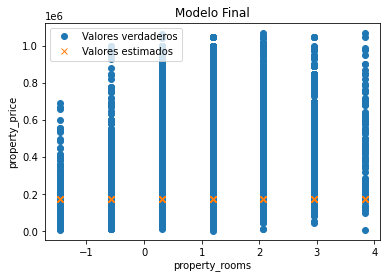

In [ ]:
plot_regression(modelo, x_train, y_train, title=f"Modelo Final",xlabel="property_rooms", ylabel="property_price")

### Utilizamos la variable Latidud

In [132]:
features_normal = ["latitud"]
target = ["property_price"]

Separamos por variable predictora y target

In [133]:
#train
x_train =ds_train[features_normal]
y_train = ds_train[target]

#test
x_test= ds_test[features_normal]
y_test= ds_test[target]

Creamos el modelo

In [110]:
"""
# Creo un modelo Red Neuronal
d_in=1
d_out=1

modelo = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 2 salidas, activación relu
    keras.layers.Dense(5,input_shape=(d_in,), activation="relu"),
    # Capa con 2 salidas, activación tanh
    keras.layers.Dense(5, activation="tanh" ),
    keras.layers.Dense(d_out, )])
"""

Elegimos la metrica

### Keras tuner busqueda de hiperparametros

In [138]:
def compilar_modelo(modelo, hp_lr):
  modelo.compile(
    optimizer=keras.optimizers.SGD(learning_rate=hp_lr), 
    loss='mse', 
    # metricas para ir calculando en cada iteracion o batch 
    metrics=[tf.keras.metrics.RootMeanSquaredError()], 
  )

In [139]:
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Choice('units', [8, 16, 32]),
      activation='relu'))
  model.add(keras.layers.Dense(1, activation='relu'))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3, 1e-4, 1e-5])
  compilar_modelo(model, hp_learning_rate)
  return model

In [140]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

In [141]:
tuner.search(x_train, y_train, epochs=5, validation_data=(x_train, y_train))
#best_model = tuner.get_best_models()[0]
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 5 Complete [00h 00m 16s]
val_loss: 50939453440.0

Best val_loss So Far: 41014673408.0
Total elapsed time: 00h 01m 21s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 8 and the optimal learning rate for the optimizer
is 1e-05.



In [142]:
#best_model.fit(x_train, y_train, epochs=100, batch_size=16, verbose=False)

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(x_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
1494/1494 [==============================] - 2s 1ms/step - loss: 49983156224.0000 - root_mean_squared_error: 223569.1250 - val_loss: 49142562816.0000 - val_root_mean_squared_error: 221681.2188
Epoch 2/50
1494/1494 [==============================] - 2s 1ms/step - loss: 48201093120.0000 - root_mean_squared_error: 219547.4688 - val_loss: 47403610112.0000 - val_root_mean_squared_error: 217723.7031
Epoch 3/50
1494/1494 [==============================] - 2s 1ms/step - loss: 46510379008.0000 - root_mean_squared_error: 215662.6562 - val_loss: 45765545984.0000 - val_root_mean_squared_error: 213928.8281
Epoch 4/50
1494/1494 [==============================] - 2s 1ms/step - loss: 44917702656.0000 - root_mean_squared_error: 211937.9688 - val_loss: 44222763008.0000 - val_root_mean_squared_error: 210292.0938
Epoch 5/50
1494/1494 [==============================] - 2s 1ms/step - loss: 43417526272.0000 - root_mean_squared_error: 208368.7344 - val_loss: 42769358848.0000 - val_root_mean_squared

In [143]:
val_acc_per_epoch = history.history['root_mean_squared_error']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 1


sacado de:
- https://github.com/karndeepsingh/keras_tuner_implementation/blob/main/HYPER_OPTIMIZATION_OF_DEEP_LEARNING_MODELS_USING_KERAS_TUNER_.ipynb
- https://keras.io/keras_tuner/

### Entrenamos el mejor modelo y lo graficamos

1867/1867 [==============================] - 1s 661us/step


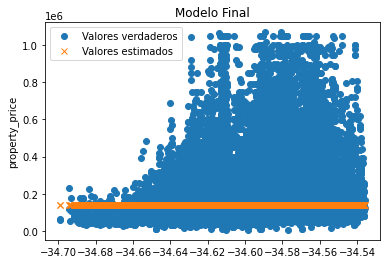

In [144]:
plot_regression(best_model, x_train, y_train, title=f"Modelo Final",xlabel="", ylabel="property_price")

In [145]:
eval_result = best_model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

508/508 [==============================] - 0s 778us/step - loss: 21232347136.0000 - root_mean_squared_error: 145713.2344
[test loss, test accuracy]: [21232347136.0, 145713.234375]


### Resultados del modelo

In [146]:
y_pred = best_model.predict(x_test)

mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)
rmse=mean_squared_error(y_test, y_pred, squared=False) 

print(f"Error absoluto medio {mae}")
print(f"Error cuadrático medio {mse}")
print(f"Raiz del error cuadrático medio {rmse}")


508/508 [==============================] - 0s 661us/step
Error absoluto medio 86869.8317016564
Error cuadrático medio 21232346865.92734
Raiz del error cuadrático medio 145713.2350403605


## Clasificacion

Dataset iniciales

In [147]:
ds_train.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,tipo_precio,property_type_Departamento,property_type_PH
0,-34.601807,-58.469965,-0.573441,-0.904594,-0.356237,-0.417925,80000.0,bajo,1,0
1,-34.580088,-58.424965,-0.573441,-0.904594,-0.609345,-0.762050,79900.0,medio,1,0
2,-34.551481,-58.452358,-1.454585,-0.904594,-0.749961,-1.130756,69000.0,medio,1,0
3,-34.632290,-58.464844,2.069988,1.417020,-0.046882,0.221165,150000.0,medio,1,0
4,-34.549279,-58.463074,-0.573441,-0.904594,-0.454668,-0.786631,85000.0,bajo,1,0


In [148]:
ds_test.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,tipo_precio,property_type_Departamento,property_type_PH
0,-34.598679,-58.499717,-1.454585,-0.904594,-0.567160,-0.934113,85000.0,medio,1,0
1,-34.574987,-58.420611,-0.573441,-0.904594,1.007737,0.098263,520000.0,alto,1,0
2,-34.586527,-58.398279,-0.573441,-0.904594,-0.496852,-0.614568,87000.0,medio,1,0
3,-34.577647,-58.406064,1.188845,1.417020,0.726505,1.278121,690000.0,alto,1,0
4,-34.560998,-58.464248,-1.454585,-0.904594,-0.637468,-0.909533,95000.0,alto,1,0


Declaro variables predictoras, de target y a eliminar

In [149]:
#Eliminamos columnas que esten relaionadas con el precio
columnas_a_eliminar = ["property_price", "property_bedrooms", "property_surface_total", "property_surface_covered", "property_price", "property_type_Departamento", "property_type_PH"]

#target
target = ["tipo_precio"]

#columnas_predictoras 
columnas_predictoras = ["latitud", "longitud", "property_rooms"]


Preparo los dataset para entrenamiento y testeo

In [150]:
ds_train_clas = ds_train.drop(columns=columnas_a_eliminar)
ds_test_clas = ds_test.drop(columns=columnas_a_eliminar)

#train
x_train = ds_train_clas.drop(columns=target)
y_train = ds_train_clas[target]

#test
x_test = ds_test_clas.drop(columns=target)
y_test = ds_test_clas[target]

Remplazo tipo_precio por numeros

- bajo = 0
- medio = 1
- alto = 2

In [151]:
y_train["tipo_precio"] = y_train["tipo_precio"].replace({"bajo": 0, "medio": 1, "alto" : 2})
y_test["tipo_precio"] = y_test["tipo_precio"].replace({"bajo": 0, "medio": 1, "alto" : 2})

C:\Users\EQUIPO~1\AppData\Local\Temp/ipykernel_6464/1025328752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train["tipo_precio"] = y_train["tipo_precio"].replace({"bajo": 0, "medio": 1, "alto" : 2})
C:\Users\EQUIPO~1\AppData\Local\Temp/ipykernel_6464/1025328752.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["tipo_precio"] = y_test["tipo_precio"].replace({"bajo": 0, "medio": 1, "alto" : 2})


In [152]:
y_train.head()

,tipo_precio
0,0
1,1
2,1
3,1
4,0


In [153]:
y_test.head()

,tipo_precio
0,1
1,2
2,1
3,2
4,2


### Creacion y entrenamiento del modelo

In [154]:
# calcula la cantidad de clases
cant_clases=len(np.unique(y_train))

d_in=len(columnas_predictoras)

modelo = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 3 salidas, activación relu
    keras.layers.Dense(3,input_shape=(d_in,), activation='relu',kernel_initializer='uniform'),
    keras.layers.Dense(3,input_shape=(d_in,), activation='relu',kernel_initializer='uniform'),
    keras.layers.Dense(cant_clases, activation='softmax')])

modelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 3)                 12        
                                                                 
 dense_5 (Dense)             (None, 3)                 12        
                                                                 
 dense_6 (Dense)             (None, 3)                 12        
                                                                 
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________


In [155]:
modelo.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.001), 
  loss='categorical_crossentropy', 
  # metricas para ir calculando en cada iteracion o batch 
  metrics=['AUC'], 
)

cant_epochs=100

historia_modelo=modelo.fit(x_train,y_train,epochs=cant_epochs,batch_size=16,verbose=False)

ValueError: in user code:

    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 3) are incompatible


In [ ]:
y_pred = modelo.predict(x_test)

y_pred = np.argmax(y_pred,axis = 1) 

print("  Accuracy : %.2f" % accuracy_score(y_test, y_pred) )
print("  Precision: %.2f" % precision_score(y_test, y_pred) )
#print("     Recall: %.2f" % recall_score(y_test, y_pred ))
#print("  f-measure: %.2f" % f1_score(y_test, y_pred))

508/508 [==============================] - 0s 921us/step
  Accuracy : 0.25


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].